In [38]:
!pip install yfinance


In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [40]:
df = yf.download(
    "TCS.NS",
    start="2022-01-01",
    end="2024-12-31",
    progress=False
)

df.dropna(inplace=True)
df.head()


/tmp/ipython-input-3361495830.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2022-01-03,3447.917969,3458.981290,3382.215387,3386.731028,2346158
2022-01-04,3508.427490,3512.401166,3442.453927,3459.974748,2488606
2022-01-05,3486.933350,3495.106705,3443.086424,3490.591064,1733031
2022-01-06,3438.615479,3463.496705,3406.599627,3442.724756,1810293
2022-01-07,3480.204834,3490.500408,3428.636121,3449.950037,2460591


In [41]:
def ADX(df, period=14):
    # Correctly access MultiIndex columns
    high = df[('High', 'TCS.NS')]
    low = df[('Low', 'TCS.NS')]
    close = df[('Close', 'TCS.NS')]

    # True Range
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Directional Movement
    plus_dm_raw = high.diff()
    minus_dm_raw = low.diff()

    # Ensure plus_dm and minus_dm are 1-dimensional Series with correct index
    # Use .values to ensure np.where operates on 1D numpy arrays
    plus_dm = pd.Series(np.where((plus_dm_raw.values > minus_dm_raw.values) & (plus_dm_raw.values > 0), plus_dm_raw.values, 0.0), index=df.index)
    minus_dm = pd.Series(np.where((minus_dm_raw.values > plus_dm_raw.values) & (minus_dm_raw.values < 0), abs(minus_dm_raw.values), 0.0), index=df.index)

    # Wilder smoothing (simple rolling for assignment)
    atr = tr.rolling(period).mean()
    plus_di = 100 * (plus_dm.rolling(period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(period).mean() / atr)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(period).mean()

    df['ADX'] = adx
    df['+DI'] = plus_di
    df['-DI'] = minus_di

    return df

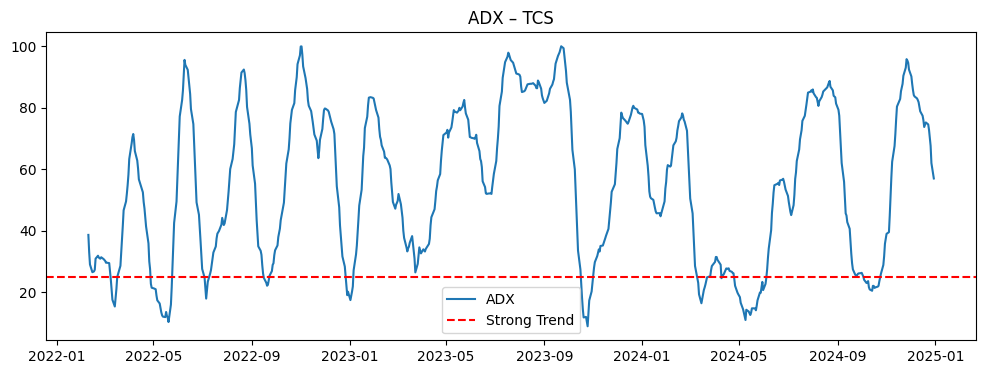

In [42]:
df = ADX(df, period=14)

plt.figure(figsize=(12,4))
plt.plot(df['ADX'], label='ADX')
plt.axhline(25, color='red', linestyle='--', label='Strong Trend')
plt.legend()
plt.title("ADX – TCS")
plt.show()


In [43]:
def VPT(df):
    vpt = [0]

    for i in range(1, len(df)):
        prev_close = df['Close'].iloc[i-1]
        curr_close = df['Close'].iloc[i]
        volume = df['Volume'].iloc[i]

        vpt_val = vpt[-1] + volume * (curr_close - prev_close) / prev_close
        vpt.append(vpt_val)

    df['VPT'] = vpt
    return df


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


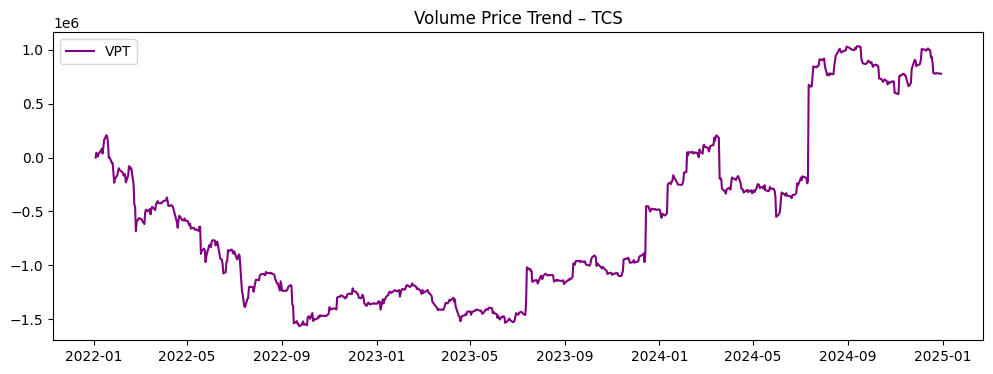

In [44]:
df = VPT(df)

plt.figure(figsize=(12,4))
plt.plot(df['VPT'], label='VPT', color='purple')
plt.legend()
plt.title("Volume Price Trend – TCS")
plt.show()


In [45]:
def DonchianChannels(df, period=20):
    df['Donchian_Upper'] = df['High'].rolling(period).max()
    df['Donchian_Lower'] = df['Low'].rolling(period).min()
    df['Donchian_Middle'] = (df['Donchian_Upper'] + df['Donchian_Lower']) / 2
    return df


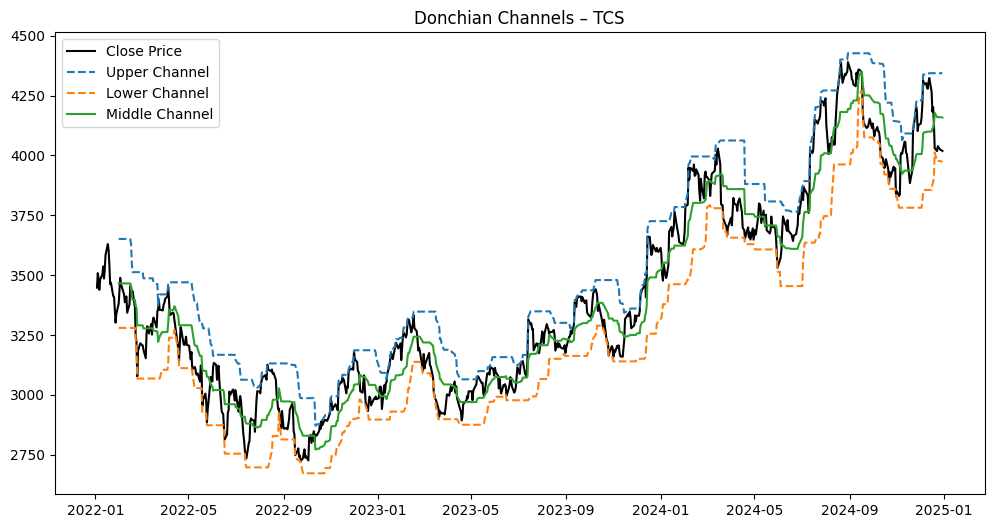

In [46]:
df = DonchianChannels(df, period=20)

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price', color='black')
plt.plot(df['Donchian_Upper'], linestyle='--', label='Upper Channel')
plt.plot(df['Donchian_Lower'], linestyle='--', label='Lower Channel')
plt.plot(df['Donchian_Middle'], label='Middle Channel')
plt.legend()
plt.title("Donchian Channels – TCS")
plt.show()
